# Policy Gradient for Optimal Control

In this notebook, we will empirically test policies for various environments, to measure the efficacy of the policies we develop in the written section on live noise. We will be using the environments defined in `environments/multiplicative_gaussian_noise_environment.py`, which will need to be completed prior to beginning this notebook. There are certain properties about these environments that are more specific than definition 2 of section 1.2 of the writeup. Here is an overview of those:
1. $A_t \sim \mathcal{N}(a, \alpha^2)$, $B_t \sim \mathcal{N}(b, \beta^2)$, and $C_t \sim \mathcal{N}(c, \gamma^2)$ are all normal distributions.
2. $X_0 = 1$ (this means $\mu = 1$, $\sigma = 0$).

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List
from torch import Tensor
from environments.base_environment import Environment
from environments.multiplicative_gaussian_noise_environment import MultiplicativeGaussianNoiseEnvironment, MultiplicativeGaussianControlNoiseEnvironment, \
                                                    MultiplicativeGaussianStateControlNoiseEnvironment, MultiplicativeGaussianObservationNoiseEnvironment

from policies.base_policy import Policy
from policies.m1p1_linear_policy_modules import FixedWeightM1P1LinearModule

from infrastructure.visualization import plot_average_second_moment_trajectory, plot_empirical_average_second_moment_and_partial_loss, plot_empirical_loss_over_a
from agent import Agent
from control_engine import ControlEngine

import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

/Users/thomaschen/Downloads/proj_pg_code_prob/infrastructure/visualization.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mathbb{E}[X_t^2]$" + (f", a={a_value}" if a_value else ""))
/Users/thomaschen/Downloads/proj_pg_code_prob/infrastructure/visualization.py:56: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title(f'Empirical $\mathbb{{E}}[X_t^2]$ for {env_type} System')


In [3]:
import os

# Patch for buggy matplotlib
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The `sim_policy` function simulates $N$ trajectories, each of $T$ timesteps, using the given policy within the given environment.

In [4]:
def sim_policy(T: int, N: int, policy: Policy, env: Environment):
    agent = Agent(policy)
    engine = ControlEngine(agent, env)
    states, _, _, losses = engine.collect_trajectories(N = 100, T = 100, use_stochastic_policy = False)
    return states, losses

# Control Noise

Write the optimal linear coefficient $\theta$ you found in Problem 3 for the control noise system as a function of $a$, $b$, and $\beta$.

In [5]:
# TODO
theta_cn = lambda a, b, beta: (-a*b) / (b**2 + beta **2)

Analyze the system where $a = 1$, $b = 1$, $\beta = 1$.

In [6]:
a = 1
b = 1
beta = 1

env = MultiplicativeGaussianControlNoiseEnvironment(
    a = a,
    b = b,
    beta = beta,
    lmbda = 0
)

linear_policy = Policy(FixedWeightM1P1LinearModule(theta_cn(a, b, beta)))
states, losses = sim_policy(100, 100, linear_policy, env)

We empirically estimate $\mathbb E[X_t^2] \approx \frac{1}{N} \sum_{i=1}^{N} (X^{(i)})^2_t$, where $X^{(i)}_t$ is the state at timestep $t$ on the $i$-th rollout.

Likewise, we define the empirical loss as $\overline{L}(F) = \sum_{t=1}^{T} \mathbb E[X_t^2] \approx \frac{1}{N} \sum_{t=1}^{T} \sum_{i=1}^{N} \Big(X^{(i)}_t\Big)^2$. It is sometimes interesting to look at the 'partial' loss; that is, the loss for the first $\tilde{t}$ timesteps. Define this as $\overline{L}(F; \tilde{t}) = \frac{1}{N} \sum_{t=1}^{\tilde{t}} \sum_{i=1}^{N} \Big(X^{(i)}_t\Big)^2$.

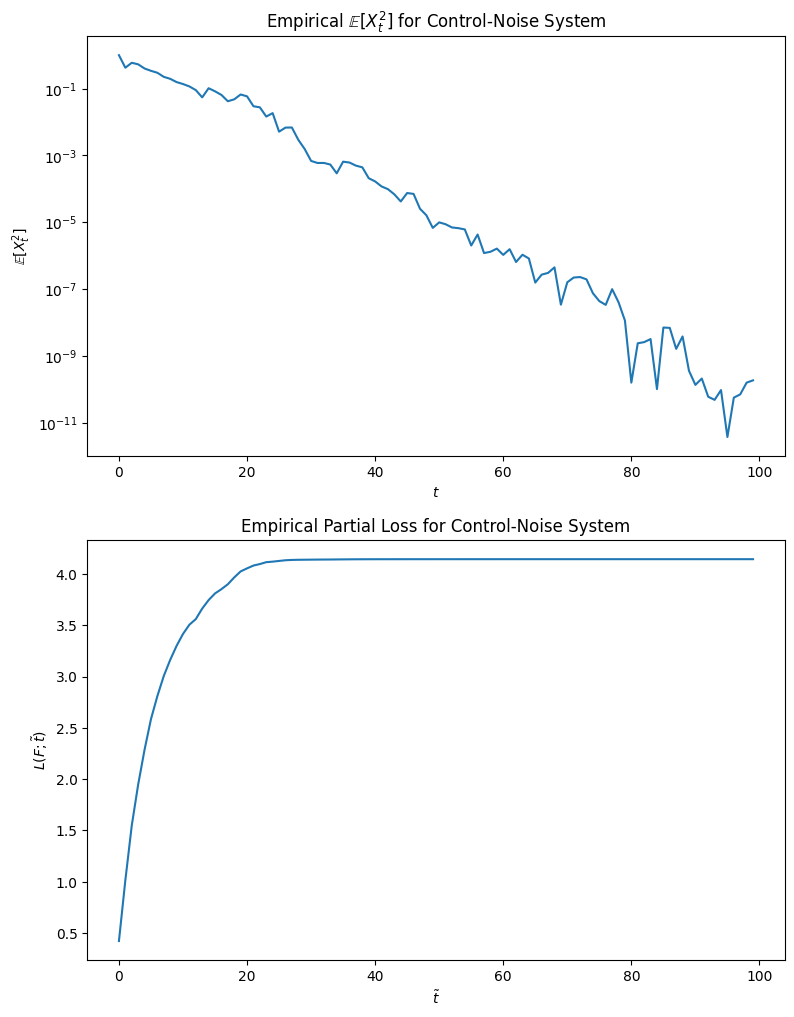

In [7]:
plot_empirical_average_second_moment_and_partial_loss(states, losses, "Control-Noise")

Now, we rerun the above simulation with different values of $a$ (again with $b = 1$ and $\beta = 1$).

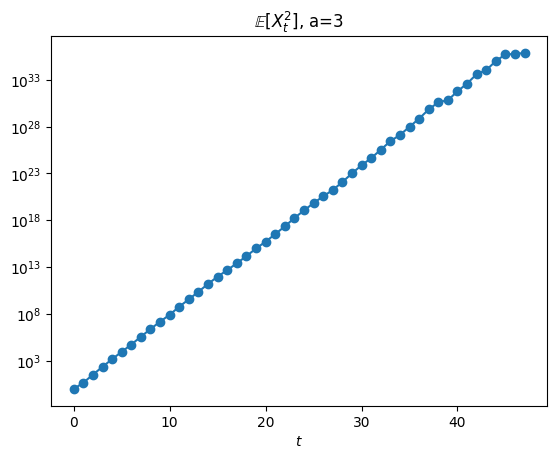

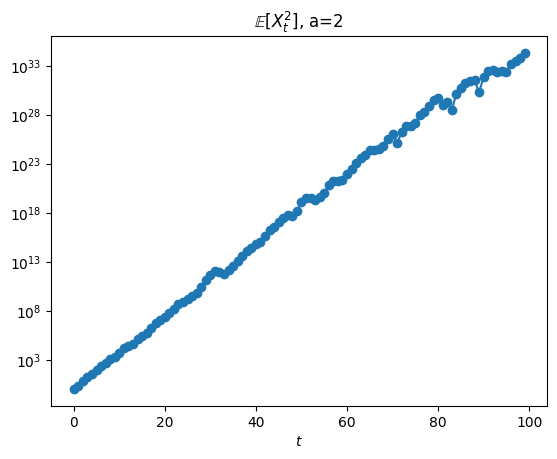

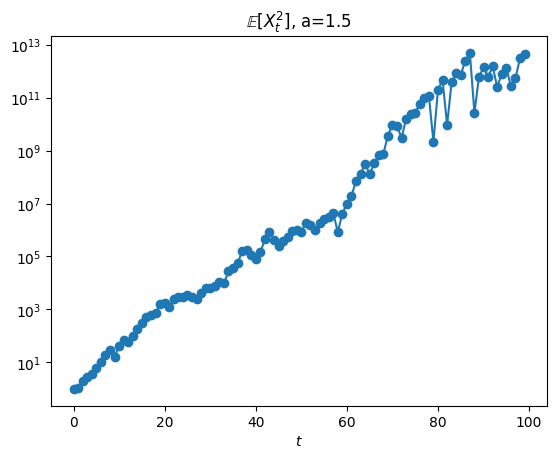

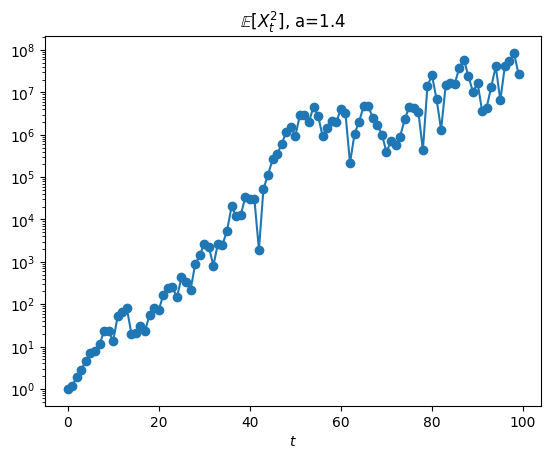

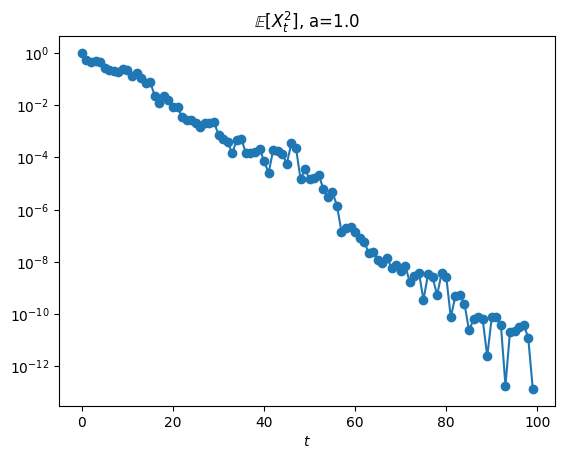

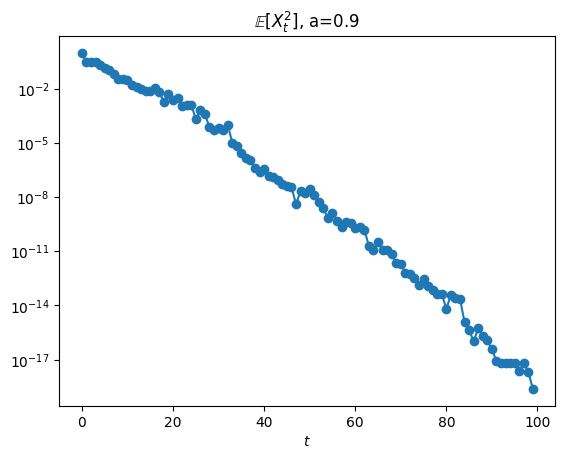

In [9]:
a_list = [3, 2, 1.5, 1.4, 1.0, 0.9]

a_losses = []

for a in a_list:
    env = MultiplicativeGaussianControlNoiseEnvironment(
        a = a,
        b = b,
        beta = beta,
        lmbda = 0
    )
    
    linear_policy = Policy(FixedWeightM1P1LinearModule(theta_cn(a, b, beta)))
    states, losses = sim_policy(100, 100, linear_policy, env)
    plot_average_second_moment_trajectory(states, a)

### What values of $a$ are stabilizable by your analysis? Do the above plots line up with your analysis?

values of A that should be less than the square root of 2 should stabilize, this lines up with our plots, except for 1.4 which is supposed to be less than square root of 2, but still grows slightly.

Now, we will examine an interesting property of the optimal policy derived in Problem 3 (b). Let $F^*$ denote this policy, and let $U_{t}^{*} = F_{t}^{*}(Y_{(t)})$. It's worth noting that this policy does not necessarily set the expected value of $X_{t + 1}$ to $0$; that is,

$$\mathbb E[X_{t+1} | Y_t] = \mathbb E[aY_t + B_tU_t^* \mid Y_{t}] \neq 0$$

whenever $\beta > 0$. We say that this policy is "biased".

We could compute another ("unbiased") policy $F^{0}$ such that 
$$\mathbb E[aY_t + B_tU_t^0 \mid Y_{t}] = 0.$$
This policy is given by $U_t^0 = F_t^0(Y_{(t)}) = -\frac{a}{b}Y_t$. When $\beta \gg 0$, the difference between these policies is quite pronounced. Since this policy does not optimize the second moment, it will perform worse (in the second-moment sense) when you compare it to the optimal second-moment-minimizing policy.

In [10]:
# TODO
theta_0 = lambda a, b, beta: -a/b

Compare both policies when $a = 1.1$, $b = 1$, and $\beta = 2$.

In [11]:
a = 1.1
b = 1
beta = 2

env = MultiplicativeGaussianControlNoiseEnvironment(
    a = a,
    b = b,
    beta = beta,
    lmbda = 0
)

### U^*
linear_policy = Policy(FixedWeightM1P1LinearModule(theta_cn(a, b, beta)))
states_star, losses_star = sim_policy(100, 100, linear_policy, env)

### U^0
linear_policy = Policy(FixedWeightM1P1LinearModule(theta_0(a, b, beta)))
states_0, losses_0 = sim_policy(100, 100, linear_policy, env)

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/nf/t6cynmr56rj513rn_dr8y4840000gn/T/ipykernel_87768/1022715562.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title('Empirical $\mathbb{E}[X_{t}^{2}]$ for Control-Noise System')
/var/folders/nf/t6cynmr56rj513rn_dr8y4840000gn/T/ipykernel_87768/1022715562.py:6: RuntimeWarning: overflow encountered in power
  mean_second_moments_0 = np.power(states_0, 2).mean(axis=0)
/var/folders/nf/t6cynmr56rj513rn_dr8y4840000gn/T/ipykernel_87768/1022715562.py:7: RuntimeWarning: overflow encountered in accumulate
  mean_cumsum_losses_0 = np.array(losses_0).cumsum(axis=1).mean(0)


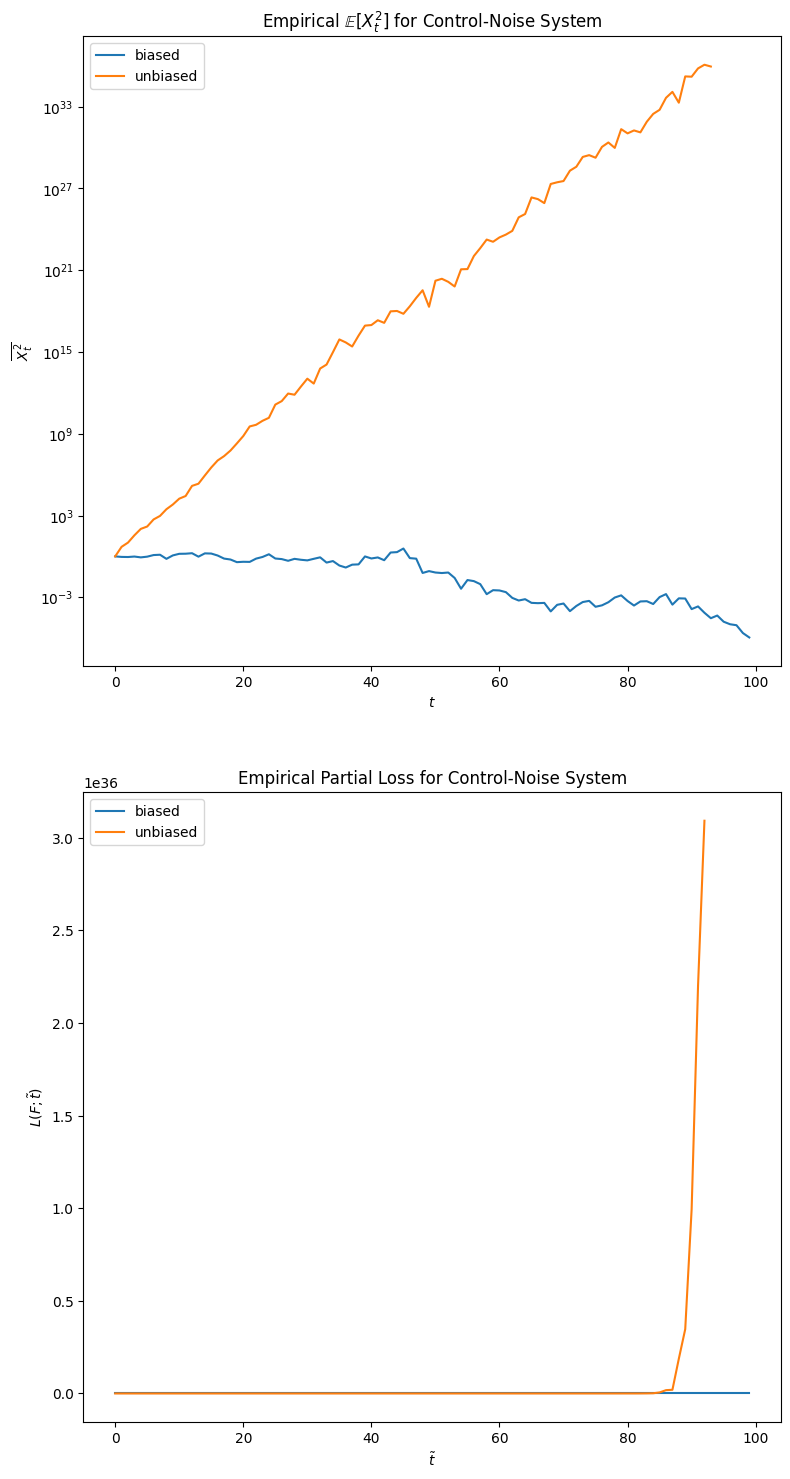

In [12]:
mean_states_star = np.array(states_star).mean(axis=0)
mean_second_moments_star = np.power(states_star, 2).mean(axis=0)
mean_cumsum_losses_star = np.array(losses_star).cumsum(axis=1).mean(0)

mean_states_0 = np.array(states_0).mean(axis=0)
mean_second_moments_0 = np.power(states_0, 2).mean(axis=0)
mean_cumsum_losses_0 = np.array(losses_0).cumsum(axis=1).mean(0)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,18))

ax[0].plot(mean_second_moments_star, label='biased')
ax[0].plot(mean_second_moments_0, label='unbiased')
ax[0].set_yscale("log")
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\overline{X_t^2}$')
ax[0].legend()
ax[0].set_title('Empirical $\mathbb{E}[X_{t}^{2}]$ for Control-Noise System')

ax[1].plot(mean_cumsum_losses_star, label='biased')
ax[1].plot(mean_cumsum_losses_0, label='unbiased')
ax[1].set_xlabel(r'$\tilde{t}$')
ax[1].set_ylabel(r'$L(F; \tilde{t})$')
ax[1].legend()
ax[1].set_title('Empirical Partial Loss for Control-Noise System')
plt.show()

### What do you notice about the difference in the empirical average state second moment $\mathbb{E}[X_t^2]$ of the biased versus unbiased policy? Which one is more stable?

the second moment is much higher for the unbiased policy than the biased one, and the biased one is more stable. 

# State-Control Noise

Write the optimal linear coefficient $\theta$ you found in Problem 4 for the state-control noise system as a function of $a$, $b$, $\alpha$, $\beta$, and $\lambda$.

In [13]:
# TODO
theta_scn = lambda a, b, alpha, beta, lmbda: -(a*b) / (b**2 + beta**2 + lmbda)

Analyze the system where $a = 1$, $b = 1$, $\alpha = 0.5$, $\beta = 0.5$, $\lambda = 1$.

In [14]:
a = 1
b = 1
alpha = 0.5
beta = 0.5
lmbda = 1

env = MultiplicativeGaussianStateControlNoiseEnvironment(
    a = a,
    b = b,
    alpha = alpha,
    beta = beta,
    lmbda = lmbda
)

linear_policy = Policy(FixedWeightM1P1LinearModule(theta_scn(a, b, alpha, beta, lmbda)))
states, losses = sim_policy(100, 100, linear_policy, env)

Plot the empirical average second moment and the partial empirical losses as we did for the control noise system.

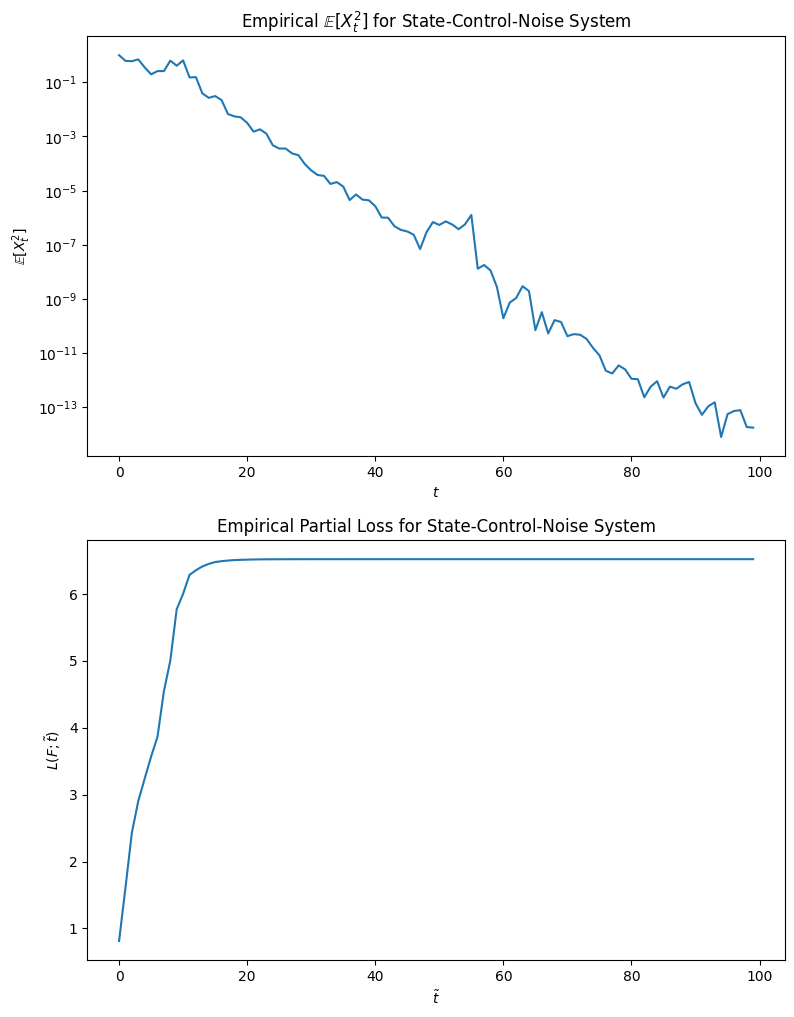

In [15]:
plot_empirical_average_second_moment_and_partial_loss(states, losses, "State-Control-Noise")

As we did in the case of Control Noise, for a variety of $a$ (and with $b = 1$, $\alpha = 0.5$, $\beta = 0.5$, and $\lambda = 1$ as above), we rerun the above simulation

X trajectory **diverged**; cannot visualize.


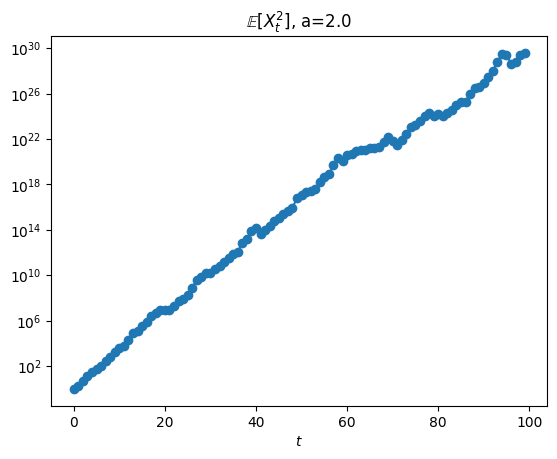

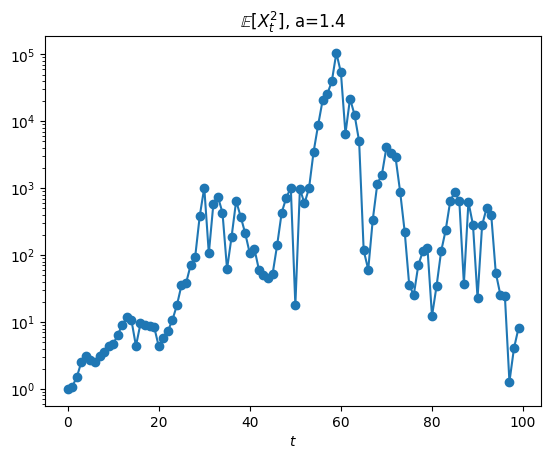

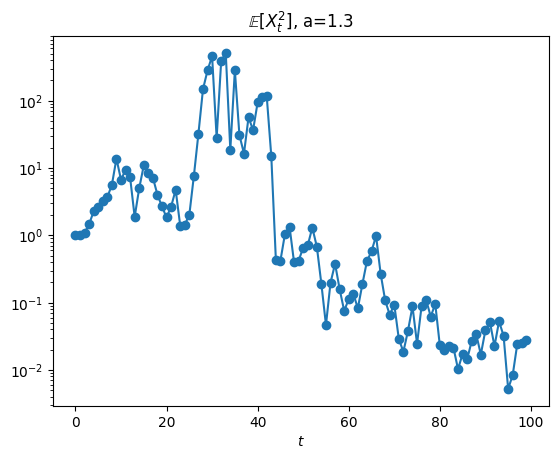

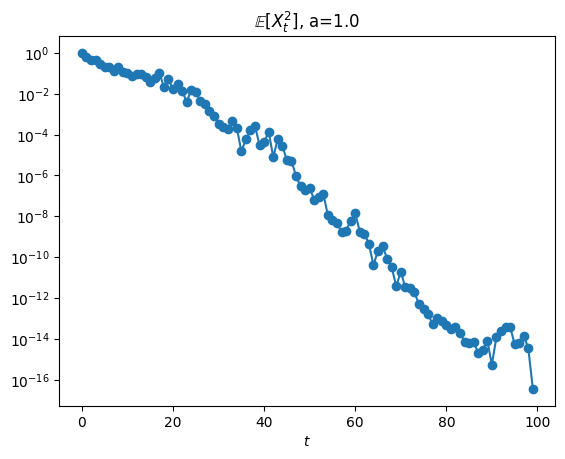

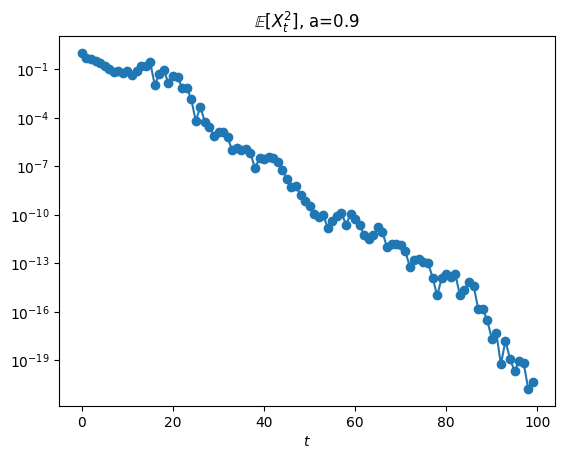

In [16]:
a_list = [3.0, 2.0, 1.4, 1.3, 1.0, 0.9]

a_losses = []

for a in a_list:
    env = MultiplicativeGaussianStateControlNoiseEnvironment(
        a = a,
        b = b,
        alpha = alpha,
        beta = beta,
        lmbda = lmbda
    )
    
    linear_policy = Policy(FixedWeightM1P1LinearModule(theta_scn(a, b, alpha, beta, lmbda)))
    states, losses = sim_policy(100, 100, linear_policy, env)
    plot_average_second_moment_trajectory(states, a)

### What values of $a$ can be stabilized by your analysis?

any a greater than approximately 2.09 in our analysis would be unstabilizable, but again it seems like when its slightly below, its already unbouded.

# Observation Noise 

Write the optimal linear coefficient $\theta$ you found in Problem 5 for the observation noise system as a function of $a$, $c$, and $\gamma$.

In [17]:
# TODO
theta_on = lambda a, c, gamma: -(a*c)/(c**2+gamma**2)

Analyze the system where $a = 1$, $c = 1$, and $\gamma = 1$.

In [18]:
a = 1
c = 1
gamma = 1

env = MultiplicativeGaussianObservationNoiseEnvironment(
    a = a,
    c = c,
    gamma = gamma,
    lmbda = 0
)

linear_policy = Policy(FixedWeightM1P1LinearModule(theta_on(a, c, gamma)))
states, losses = sim_policy(100, 100, linear_policy, env)

Plot the empirical average second moment and the partial empirical losses.

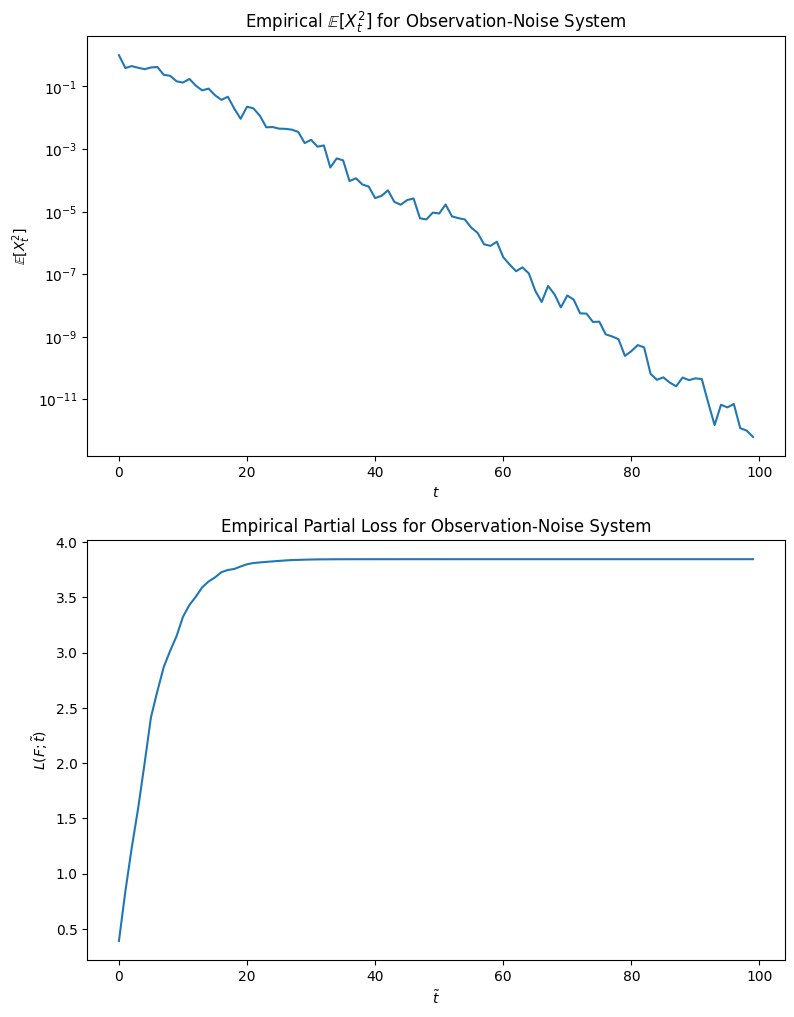

In [19]:
plot_empirical_average_second_moment_and_partial_loss(states, losses, "Observation-Noise")

### How does the perfomance of this policy compare to the perfromance of the greedy linear policy in the control noise case illustrated in the begining of the notebook?

It performs equally as good

As we did in the case of Control and State-Control Noise systems, for a variety of $a$, $c = 1$, $\gamma = 1$ (as above), rerun the above simulation and save $\overline{L}(F^*)$.

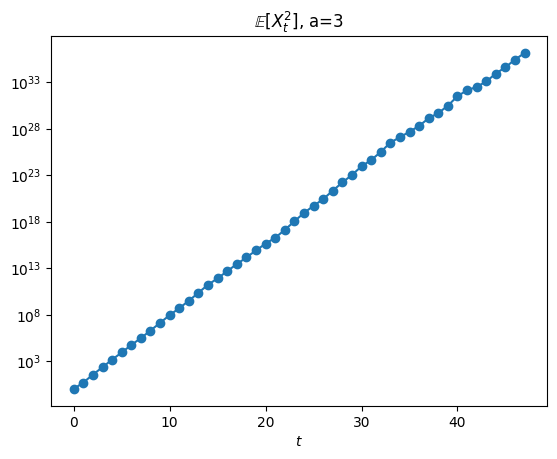

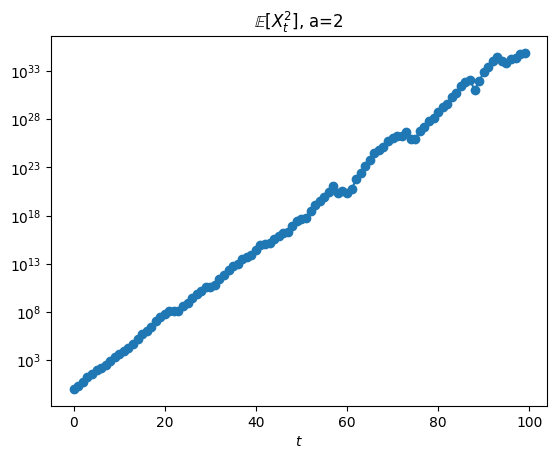

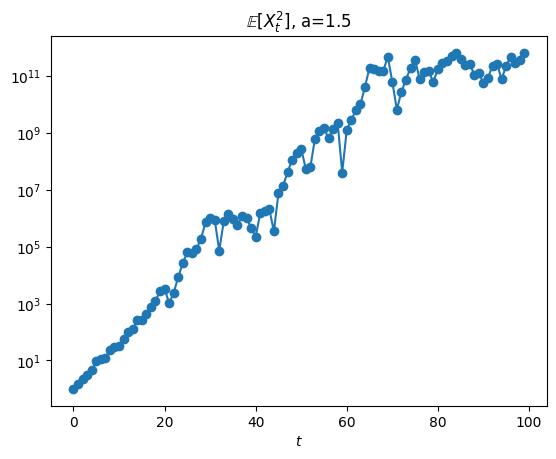

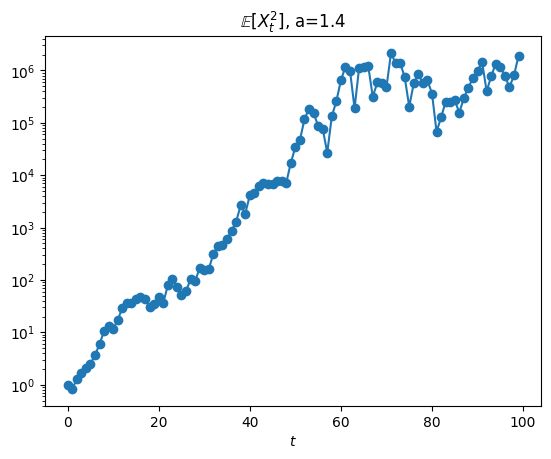

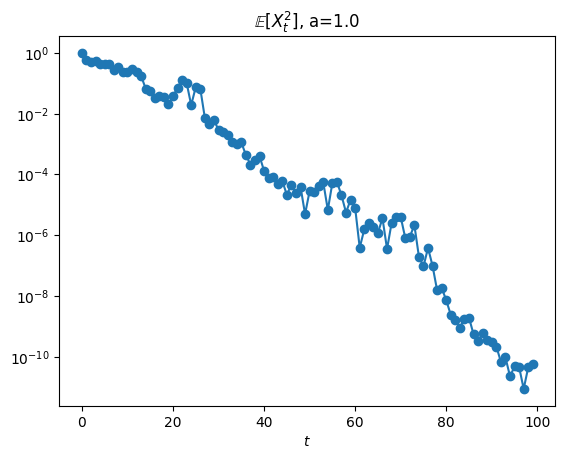

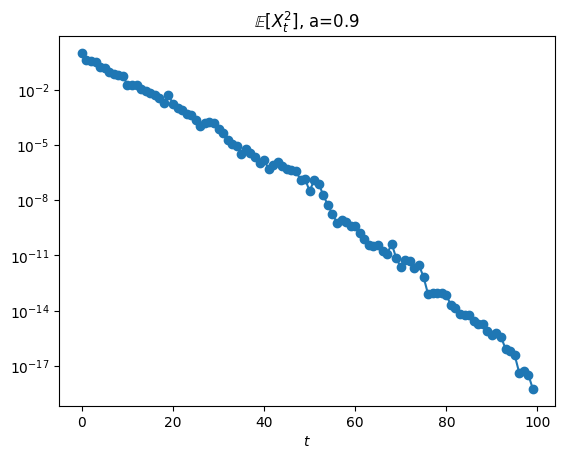

In [20]:
a_list = [3, 2, 1.5, 1.4, 1.0, 0.9]

a_losses = []

for a in a_list:
    env = MultiplicativeGaussianObservationNoiseEnvironment(
        a = a,
        c = c,
        gamma = gamma,
        lmbda = 0
    )

    linear_policy = Policy(FixedWeightM1P1LinearModule(theta_on(a, c, gamma)))
    states, losses = sim_policy(100, 100, linear_policy, env)
    plot_average_second_moment_trajectory(states, a)

### What values of $a$ are stabilizable by your analysis? Does the above graph line up with your analysis?

Once again, when a is 1 or below, it stabilizes, which is close to our analysis that anything greater than root 2 won't stabilize, however, 1.4 should stabilize but seems to grow still.

# Period-1 vs Period-2 Policies for Observation Noise

Implement the memory-1 period-2 policy defined in Problem 5 (f) as $F'_t(Y_{(t)}) = \begin{cases}\frac{1}{2} + \frac{2}{5}|Y_{t}| & \text{if \(t\) is even} \\ -\frac{1}{2} - \frac{1}{2}|Y_{t}| & \text{if \(t\) is odd.}\end{cases}$

In [21]:
class FPrimeModule(torch.nn.Module):
    def forward(self, y_history: List[Tensor]):  # List[()] -> ()
        """
        Given the most recent observation, returns a control F_t(Y_t) = 0.5 + 0.4 * |Y_t| when t is even 
        and -0.5 - 0.5 * |Y_t| when t is odd.
        """
        t = len(y_history)

        return 0.5 + 0.4 * y_history[-1] if t %2 == 0 else -0.5 - 0.5 * y_history[-1]

When $a = 1$, $c = 0$, $\gamma = 1$, compare $F^*$ (the policy derived in Problem 5 (b)) to $F'$. 

In [22]:
a = 1
c = 0
gamma = 1

env = MultiplicativeGaussianObservationNoiseEnvironment(
    a = a,
    c = c,
    gamma = gamma,
    lmbda = 0
)

### F^*
linear_policy = Policy(FixedWeightM1P1LinearModule(theta_on(a, c, gamma)))
states_star, losses_star = sim_policy(100, 100, linear_policy, env)

### F^'
p2_policy = Policy(FPrimeModule())
states_prime, losses_prime = sim_policy(100, 100, p2_policy, env)

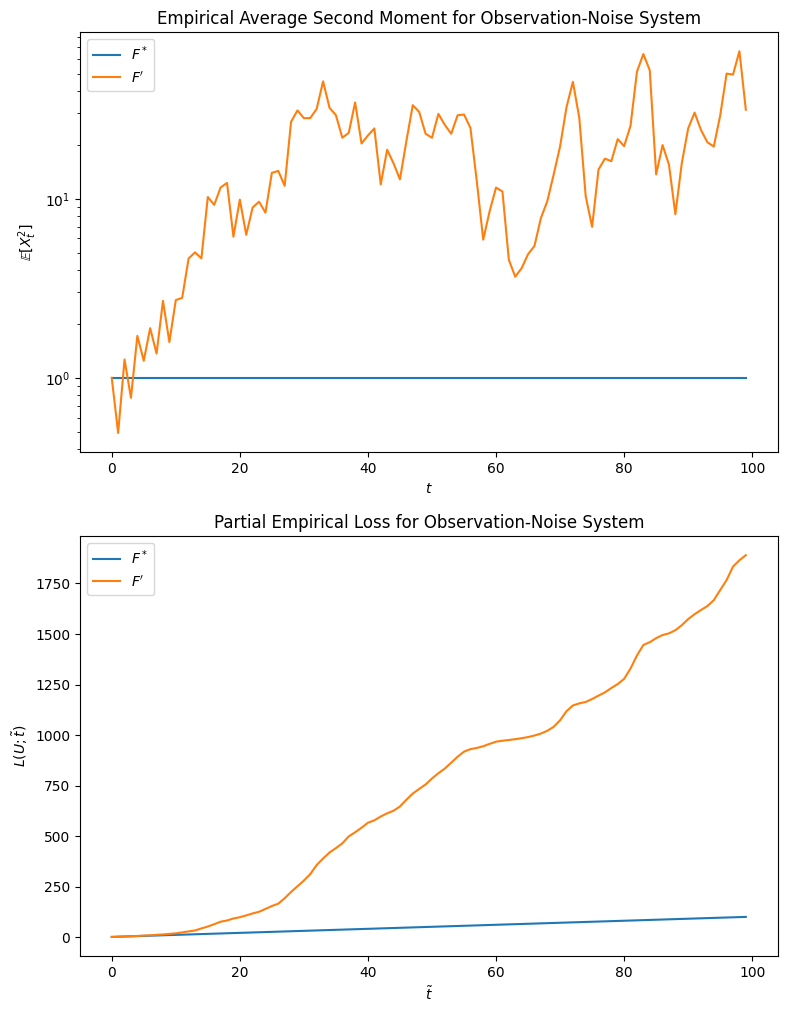

In [23]:
mean_second_moments_star = np.power(states_star, 2).mean(axis=0)
mean_cumsum_losses_star = np.array(losses_star).cumsum(axis=1).mean(0)

mean_second_moments_prime = np.power(states_prime, 2).mean(axis=0)
mean_cumsum_losses_prime = np.array(losses_prime).cumsum(axis=1).mean(0)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,12))

ax[0].plot(mean_second_moments_star, label=r"$F^*$")
ax[0].plot(mean_second_moments_prime, label=r"$F'$")
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\mathbb{E}[X_t^2]$')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('Empirical Average Second Moment for Observation-Noise System')

ax[1].plot(mean_cumsum_losses_star, label=r"$F^*$")
ax[1].plot(mean_cumsum_losses_prime, label=r"$F'$")
ax[1].set_xlabel(r'$\tilde{t}$')
ax[1].set_ylabel(r'$L(U; \tilde{t})$')
ax[1].legend()
ax[1].set_title('Partial Empirical Loss for Observation-Noise System')
plt.show()

### By comparing the performance of $F^*$ to the perfromance of $F'$, is $F^*$ the overall optimal policy for the observation noise system (as it is the case for the control noise and state-control noise systems)? 

Yes F* is the overall optimal policy for observation noise

Note from the plots above that the optimal linear memory-1 period-1 policy is in fact $F^*(Y_t) = 0$ when $C = 0$. Hence, $X_{t} = a^t\cdot X_0$ so when $|a| > 1$, this policy will necessarily not stabilize in the second moment. It remains unanswered, however, whether $F'$ can stabilize a system with $|a| > 1$.

Repeat the above analysis with $a = 1.01$, $c = 0$, $\gamma = 1$.

In [24]:
a = 1.01
c = 0
gamma = 1

env = MultiplicativeGaussianObservationNoiseEnvironment(
    a = a,
    c = c,
    gamma = gamma,
    lmbda = 0
)

### F^*
linear_policy = Policy(FixedWeightM1P1LinearModule(theta_on(a, c, gamma)))
states_star, losses_star = sim_policy(100, 100, linear_policy, env)

### F^'
p2_policy = Policy(FPrimeModule())
states_prime, losses_prime = sim_policy(100, 100, p2_policy, env)

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/nf/t6cynmr56rj513rn_dr8y4840000gn/T/ipykernel_87768/4016567400.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title('Empirical $\mathbb{E}[X_t^2]$ for Observation-Noise System')


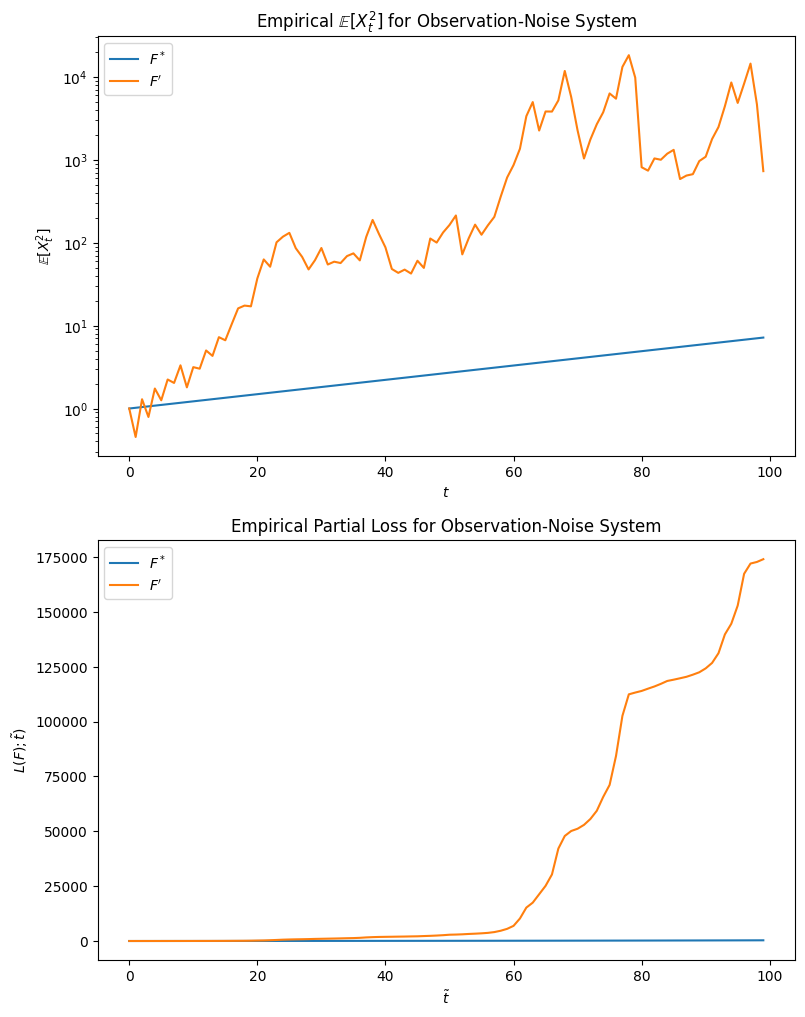

In [25]:
mean_second_moments_star = np.power(states_star, 2).mean(axis=0)
mean_cumsum_losses_star = np.array(losses_star).cumsum(axis=1).mean(0)

mean_second_moments_prime = np.power(states_prime, 2).mean(axis=0)
mean_cumsum_losses_prime = np.array(losses_prime).cumsum(axis=1).mean(0)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,12))

ax[0].plot(mean_second_moments_star, label=r"$F^*$")
ax[0].plot(mean_second_moments_prime, label=r"$F'$")
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\mathbb{E}[X_t^2]$')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('Empirical $\mathbb{E}[X_t^2]$ for Observation-Noise System')

ax[1].plot(mean_cumsum_losses_star, label=r"$F^*$")
ax[1].plot(mean_cumsum_losses_prime, label=r"$F'$")
ax[1].set_xlabel(r'$\tilde{t}$')
ax[1].set_ylabel(r'$L(F); \tilde{t})$')
ax[1].legend()
ax[1].set_title('Empirical Partial Loss for Observation-Noise System')
plt.show()

### By inspection, does $F'$ seem to stabilize this system?

Not really

# Playground - Try something cool!